In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

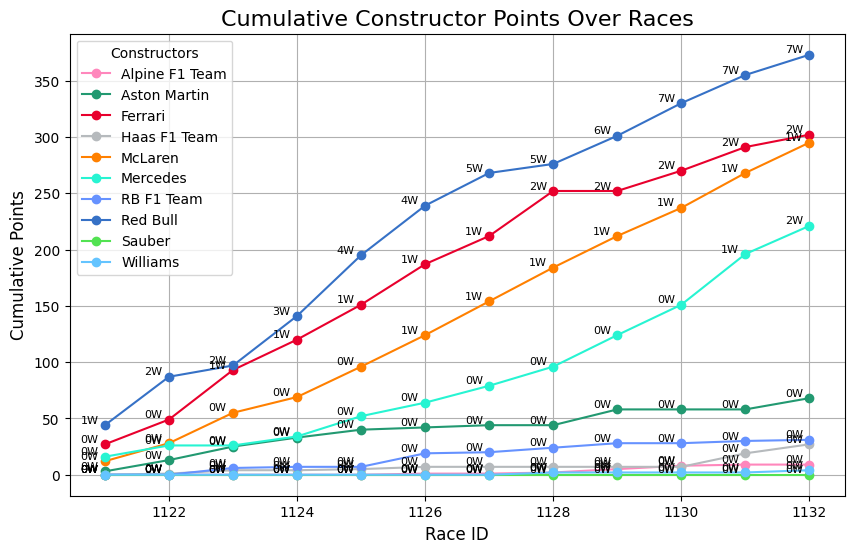

In [75]:
races_df = pd.read_csv('datasets/races.csv')
races_df = races_df[races_df['year'] == 2024][['raceId', 'round', 'date', 'name']] # get the races for the 2024 season

constructor_standings_df = pd.read_csv('datasets/constructor_standings.csv')
constructor_standings_df = constructor_standings_df[constructor_standings_df['raceId'].isin(races_df['raceId'])].drop(columns='constructorStandingsId')

constructors_df = pd.read_csv('datasets/constructors.csv')
constructors_df = constructors_df[constructors_df['constructorId'].isin(constructor_standings_df['constructorId'])]
constructors_df.drop(columns=['constructorRef', 'nationality', 'url'], inplace=True)


constructor_standings_df = pd.merge(constructor_standings_df, constructors_df, on='constructorId')
constructor_standings_df.drop(columns=['constructorId', 'positionText'], inplace=True)

constructor_standings_df.sort_values(by=['raceId', 'position'], inplace=True)

team_colors = {
    'McLaren': '#FF8000',
    'Mercedes': '#27F4D2',
    'Red Bull': '#3671C6',
    'Ferrari': '#E8002D',
    'Alpine F1 Team': '#FF87BC',
    'RB F1 Team': '#6692FF',
    'Aston Martin': '#229971',
    'Williams': '#64C4FF',
    'Sauber': '#52E252',
    'Haas F1 Team': '#B6BABD'
}

# Plotting cumulative points over races
plt.figure(figsize=(10, 6))
for constructor_name, group in constructor_standings_df.groupby('name'):
    plt.plot(
        group['raceId'], 
        group['points'], 
        marker='o', 
        label=constructor_name,
        color=team_colors[constructor_name]
    )
    # Annotating the plot with position and wins
    for i, row in group.iterrows():
        plt.text(
            row['raceId'] - 0.1, 
            row['points'], 
            f"{row['wins']}W", 
            fontsize=8,
            ha='right', 
            va='bottom'
        )

plt.title("Cumulative Constructor Points Over Races", fontsize=16)
plt.xlabel("Race ID", fontsize=12)
plt.ylabel("Cumulative Points", fontsize=12)
plt.legend(title="Constructors")
plt.grid()
plt.show()

c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib

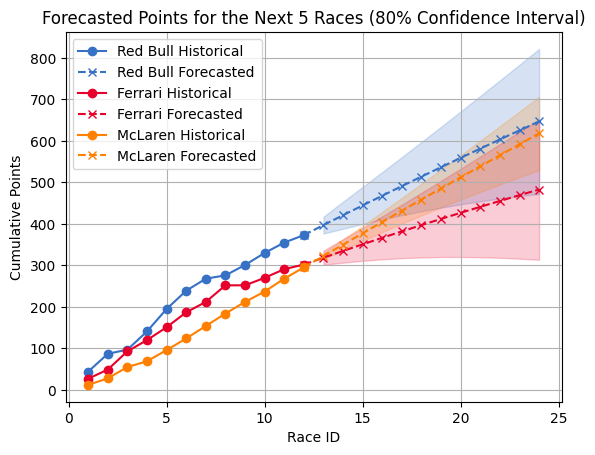

In [68]:
from statsmodels.tsa.arima.model import ARIMA

top_teams_list = ['Red Bull', 'Ferrari', 'McLaren']
top_teams_standings_df = constructor_standings_df[constructor_standings_df['name'].isin(top_teams_list)][['raceId', 'points', 'name']]
top_teams_standings_df['raceId'] = top_teams_standings_df['raceId'] - 1120

for team in top_teams_list:
    team_df = top_teams_standings_df[top_teams_standings_df['name'] == team]
    team_df = team_df.set_index('raceId')

    model = ARIMA(team_df['points'], order=(1,1,1))
    model_fit = model.fit()
    forecast_result = model_fit.get_forecast(steps=12)
    forecast = forecast_result.predicted_mean
    stderr = forecast_result.se_mean
    conf_int = forecast_result.conf_int(alpha=0.20)  # 80% confidence interval

    # Add the last actual value to the forecasts so the two lines connect
    last_actual = team_df['points'].iloc[-1]
    forecast_with_actual = [last_actual] + list(forecast)

    # Plot the historical data (points) for the team
    plt.plot(team_df.index, team_df['points'], label=f'{team} Historical', linestyle='-', marker='o', color=team_colors[team])

    # Plot the forecasted points for the team
    future_raceIds = range(team_df.index[-1] + 1, team_df.index[-1] + 13)
    plt.plot([team_df.index[-1]] + list(future_raceIds), forecast_with_actual, label=f'{team} Forecasted', linestyle='--', marker='x', color=team_colors[team])

    # Plot confidence intervals
    plt.fill_between(future_raceIds, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.2, color=team_colors[team])


plt.xlabel('Race ID')
plt.ylabel('Cumulative Points')
plt.title('Forecasted Points for the Next 5 Races (80% Confidence Interval)')
plt.legend()
plt.grid(True)
plt.show()


